<h1>
Исследовательская работа - анализ данных покупательского поведения клиентов интернет магазина "В один клик"
</h1>

<h2>Цели работы</h2>
<ul>
    <li>
        Анализ основных показателей данных
    </li>
    <li>
        Построение пайплайна модели и нахождение оптимальной модели и её гиперпараметров 
    </li>
    <li>
        Анализ важности признаков модели
    </li>
    <li>
        Сегментация покупателей
    </li>
</ul>

In [1]:
pip install numpy==1.23 numba==0.60 shap matplotlib==3.7.0 phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install scikit-learn -U

In [3]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import os

import seaborn as sns

## Загрузка данных

In [ ]:
market_file_path_local = './data/market_file.csv'
market_file_path_yandex = '/datasets/market_file.csv'

market_money_path_local = './data/market_money.csv'
market_money_path_yandex = '/datasets/market_money.csv'

market_time_path_local = './data/market_time.csv'
market_time_path_yandex = '/datasets/market_time.csv'

money_df_path_local = './data/money.csv'
money_df_path_yandex = '/datasets/money.csv'

In [5]:
if os.path.exists(market_file_path_local):
	market_file = pd.read_csv(market_file_path_local)
else:
	market_file = pd.read_csv(market_file_path_yandex)
display(market_file.head(10))

if os.path.exists(market_money_path_local):
	market_money = pd.read_csv(market_money_path_local)
else:
	market_money = pd.read_csv(market_money_path_yandex)
display(market_money.head(10))

if os.path.exists(market_time_path_local):
	market_time = pd.read_csv(market_time_path_local)
else:
	market_time = pd.read_csv(market_time_path_yandex)
display(market_time.head(10))

if os.path.exists(money_df_path_local):
	money_df = pd.read_csv(money_df_path_local, sep = ';', decimal=',')
else:
	money_df = pd.read_csv(money_df_path_yandex, sep = ';', decimal=',')
display(money_df.head(10))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


##  Предобработка данных

In [6]:
display(market_file.head(10))
print(market_file.columns)
print(market_file.info())
print(market_file.shape)
print(market_file[market_file.duplicated()]['id'].count())
market_file = market_file.rename(columns={
    'Покупательская активность': 'покупательская_активность',
    'Тип сервиса': 'тип_сервиса',
    'Разрешить сообщать': 'разрешить_сообщать',
    'Маркет_актив_6_мес': 'маркет_актив_6_мес',
    'Маркет_актив_тек_мес': 'маркет_актив_тек_мес', 
    'Длительность': 'длительность',
    'Акционные_покупки': 'акционные_покупки',
    'Популярная_категория': 'популярная_категория', 
    'Средний_просмотр_категорий_за_визит': 'средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал': 'неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса': 'ошибка_сервиса', 
    'Страниц_за_визит': 'страниц_за_визит',
})
market_file['тип_сервиса'] = market_file['тип_сервиса'].apply(lambda x: 'стандарт' if x != 'премиум' else x)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Д

In [7]:
display(market_money.head(10))
print(market_money.columns)
print(market_money.info())
print(market_money.shape)
market_money = market_money.rename(columns = {
	'Период': 'период',
	'Выручка' : 'выручка'
})
print(market_money[market_money.duplicated()]['id'].count())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


Index(['id', 'Период', 'Выручка'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None
(3900, 3)
0


<p>
    Смотрим на данные из таблицы с информацией о выручке, приводим названия столбцов к единому формату, проверяем на дубликаты и проверяем типы данных. 
</p>

In [8]:
display(market_time.head(10))
print(market_time.columns)
print(market_time.info())
print(market_time.shape)
market_time = market_time.rename(columns = {
	'Период': 'период'
})
print(market_time['период'].unique())
market_time['период'] = market_time['период'].apply(lambda x: x if x == 'текущий_месяц' else 'предыдущий_месяц')
print(market_time[market_time.duplicated()]['id'].count())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Index(['id', 'Период', 'минут'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None
(2600, 3)
['текущий_месяц' 'предыдцщий_месяц']
0


<p>
    Смотрим на данные из таблицы с информацией об активности пользователей на сайте, приводим название столбца к единому формату, проверяем на дубликаты и проверяем типы данных, удаляем опечатку в названии периода предыдущего месяца. 
</p>

In [9]:
display(money_df.head(10))
print(money_df.columns)
print(money_df.info())
print(money_df.shape)
money_df = money_df.rename(columns = {
	'Прибыль': 'прибыль'
})
print(money_df[money_df.duplicated()]['id'].count())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


Index(['id', 'Прибыль'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None
(1300, 2)
0


<p>
    Смотрим на данные из таблицы с информацией о прибыли каждого пользователя, переименовываем столбец, проверяем на дубликаты.
</p>

### Исследовательский анализ

In [10]:
def plotHistForCategorialColumn(columnName, dataFrame = market_file):
    ax = sns.countplot(y = columnName, data = dataFrame, label = columnName)
    ax.set_xlabel('Количество экземпляров')
    ax.set_title('График распределения ' + columnName + ' по категориям')

In [11]:
def plotGraphsForContiniousColumn(columnName, bins = 30, dataFrame = market_file):
	fig, axes = plt.subplots(1, 2, figsize=(15, 10))

	sns.histplot(ax=axes[0], x=dataFrame[columnName], bins = bins)
	axes[0].set_title('Гистограмма для ' + columnName)
	axes[0].set(ylabel = 'Количество экземпляров')

	sns.boxplot(ax=axes[1], x=dataFrame[columnName])
	axes[1].set_title('Боксплот для ' + columnName)

In [12]:
market_file_continious_columns = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'страниц_за_визит'   
]

market_file_discrete_columns = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса'
]

market_file_amount_columns = market_file_continious_columns + market_file_discrete_columns

market_file_categor_columns = [
    'популярная_категория',
    'тип_сервиса',
    'покупательская_активность',
	'разрешить_сообщать'
]

In [13]:
for columnName in market_file_amount_columns:
	print(columnName, '\n')
	print(market_file[columnName].describe(), '\n')

маркет_актив_6_мес 

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 

длительность 

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 

акционные_покупки 

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 

страниц_за_визит 

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64 

маркет_актив_тек_мес 

count    1300.000000
mean        4.011538
std         0.696868
min 

<p>
	Смотрим на описание количественных признаков, на первый взгляд аномалии можно заметить только для признака длительности, но скорее всего это объясняется просто тем, что пользователь открыл сайт, а затем его отвлекли более важны дела и он просто забыл про вкладку с интернет магазином. 
</p>

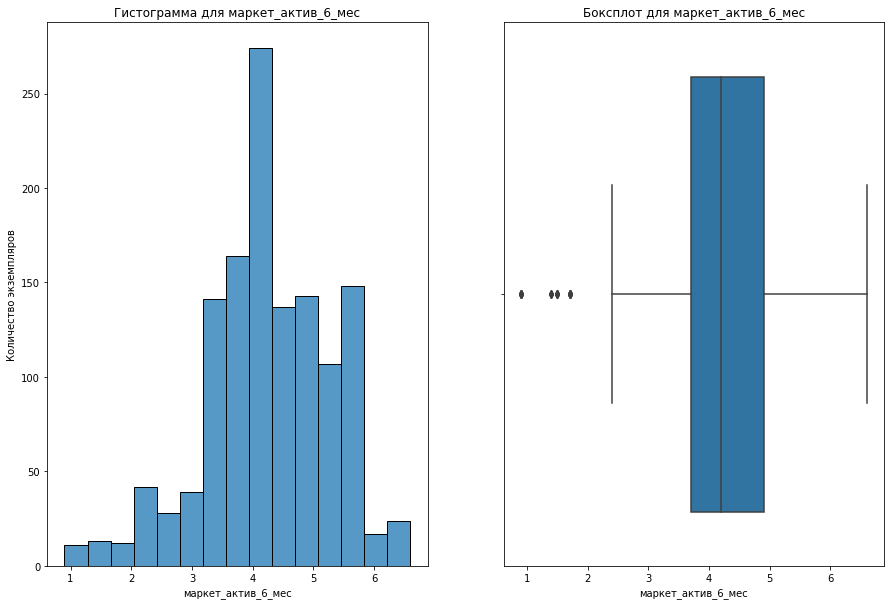

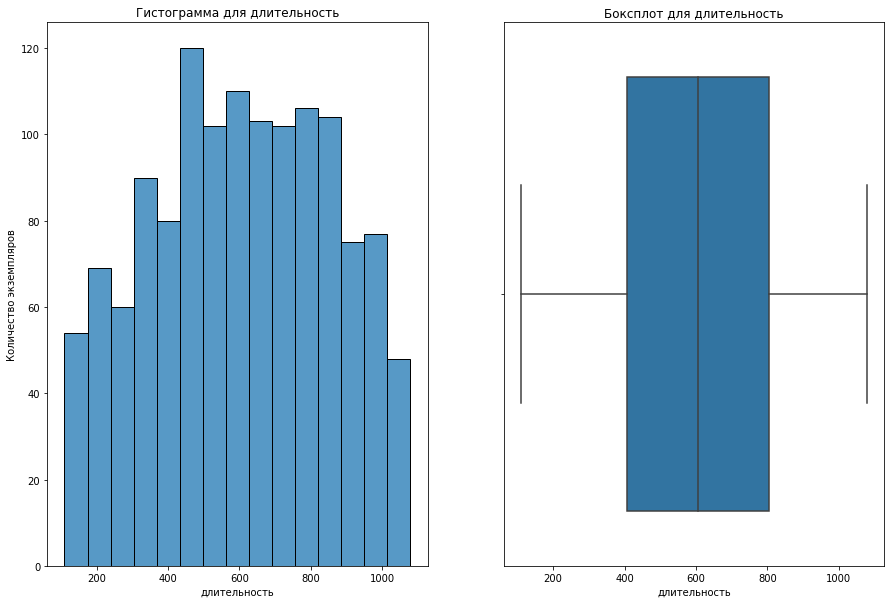

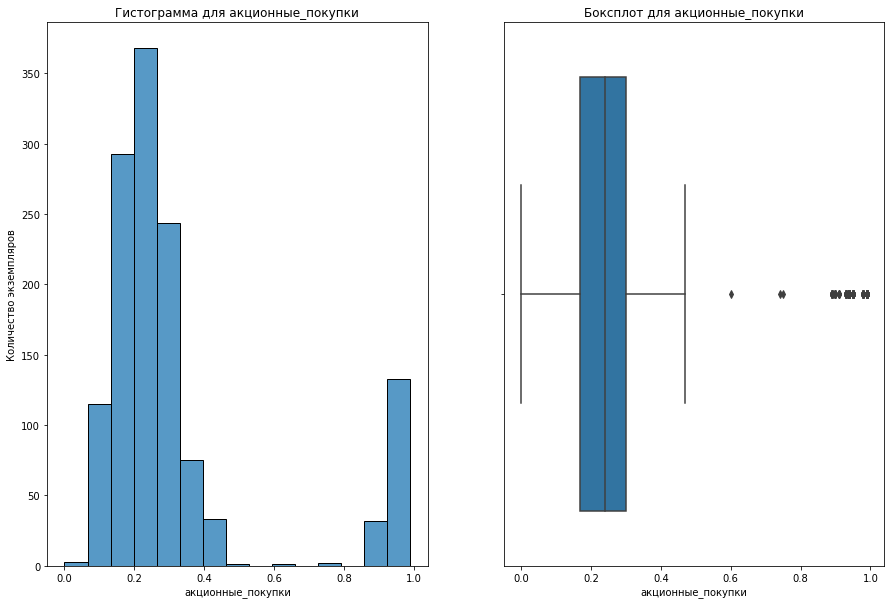

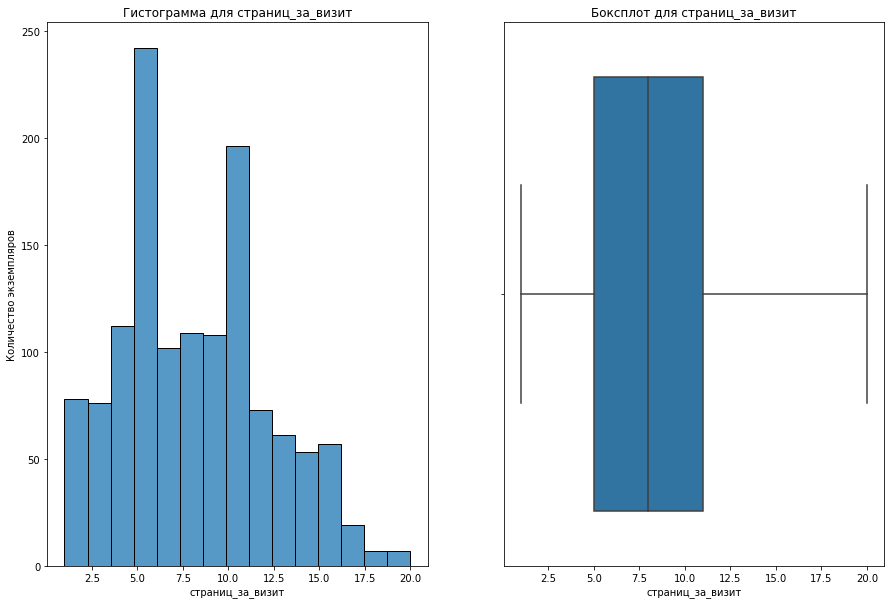

In [14]:
for column in market_file_continious_columns:
	plotGraphsForContiniousColumn(column, bins = 15)

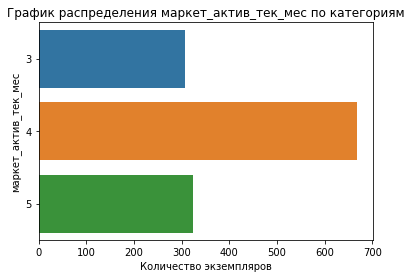

In [15]:
plotHistForCategorialColumn('маркет_актив_тек_мес')

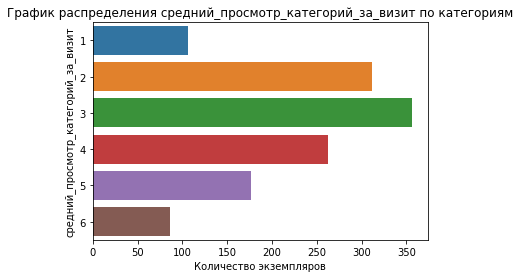

In [16]:
plotHistForCategorialColumn('средний_просмотр_категорий_за_визит')

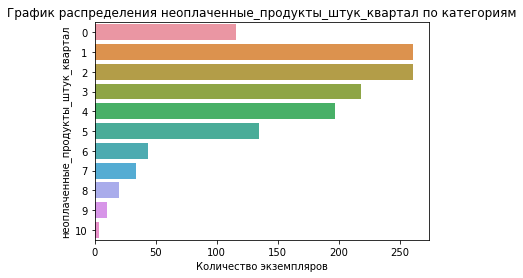

In [17]:
plotHistForCategorialColumn('неоплаченные_продукты_штук_квартал')

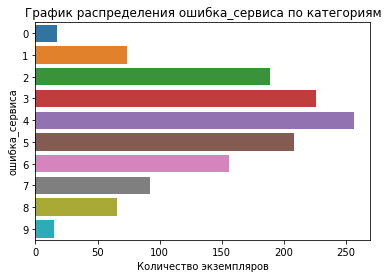

In [18]:
plotHistForCategorialColumn('ошибка_сервиса')

In [19]:
print(market_file['маркет_актив_тек_мес'].unique())

[5 4 3]


<p>
	Строим для каждого количественного признака гистограмму и ящик с усами чтобы оценить распределение и возможные выбросы для них. Из графиков видно визуально очень необычное отображение маркетинговой активности в текущем месяце и существенное количество выбросов в акционных покупках. 
</p>
<p>
	Первое можно объяснить тем, что в колонке "маркет_актив_тек_мес" всего 3 (три) уникальных значения, что конечно делает её рассмотрение при помощи boxplot несколько бессмысленным, а второй момент скорее всего объясняется тем, что есть крупная группа пользователей, которая всегда(или почти всегда)  покупает что-то только по акции. 
</p>

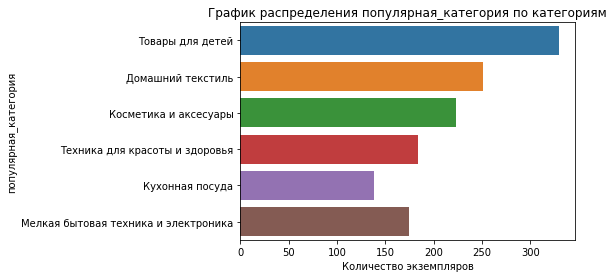

In [20]:
plotHistForCategorialColumn('популярная_категория')

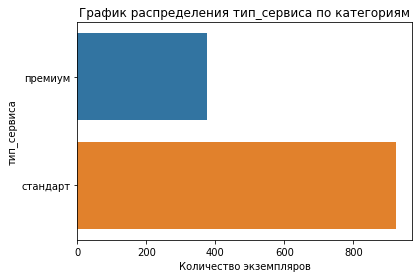

In [21]:
plotHistForCategorialColumn('тип_сервиса')

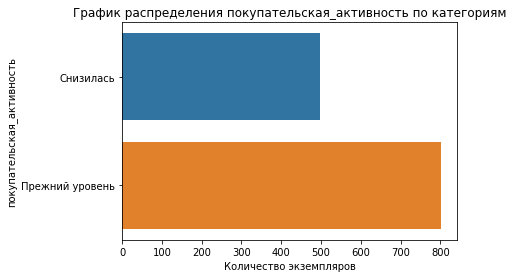

In [22]:
plotHistForCategorialColumn('покупательская_активность')

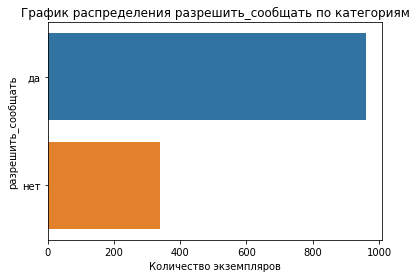

In [23]:
plotHistForCategorialColumn('разрешить_сообщать')

<p>
	Строим распределения для категориальных признаков из той же таблицы, тут сложно сказать что-то примечательное, признаки распределились некоторым образом, из графика не видно явных аномалий. 
</p>

In [24]:
market_money_num_columns = ['выручка']
market_money_cat_columns = ['период']

In [25]:
for columnName in market_money_num_columns:
	print(columnName, '\n')
	print(market_money[columnName].describe(), '\n')

выручка 

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64 



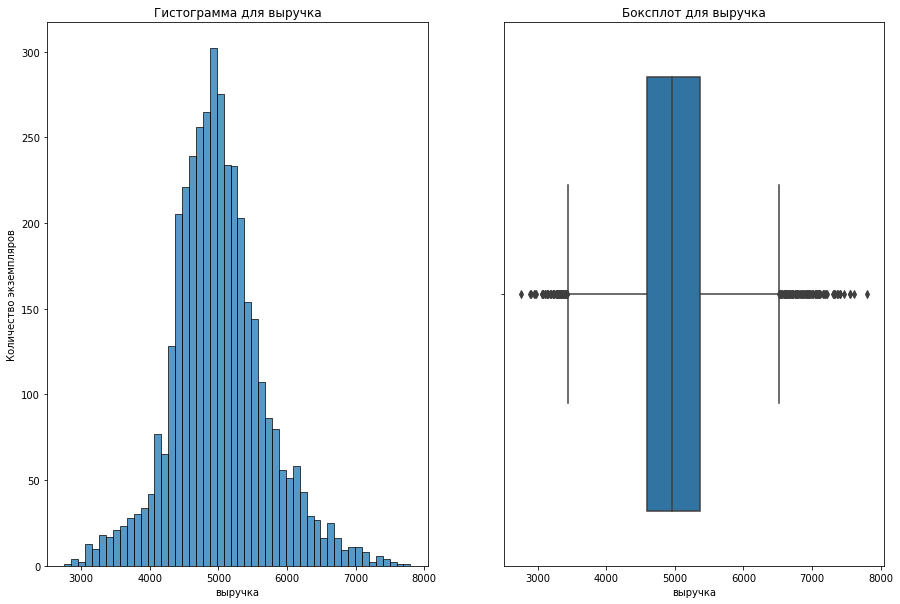

In [26]:
for column in market_money_num_columns:
	plotGraphsForContiniousColumn(column, bins = 50, dataFrame=market_money.query('выручка < 100000 and выручка > 0'))

In [27]:

ids_for_drop = market_money.query('выручка == 0')['id'].unique()
ids_for_drop = np.concatenate((ids_for_drop, market_money.query('выручка > 10000')['id'].unique()))
market_money = market_money.query('id not in @ids_for_drop')
market_file = market_file.query('id not in @ids_for_drop')
market_time = market_time.query('id not in @ids_for_drop')
money_df = money_df.query('id not in @ids_for_drop')

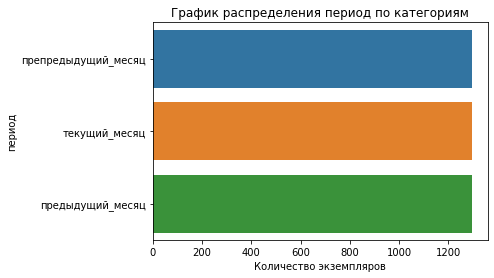

In [28]:
for column in market_money_cat_columns:
	plotHistForCategorialColumn(column, dataFrame=market_money)

<p>
	Проводим аналогичный набор операций для таблицы с выручкой, удаляем явный выброс со значением более 10000 и пользователей с нулевой выручкой хотя бы в одном месяце из всех датафреймов. 
</p>

In [29]:
market_time_num_columns = ['минут']
market_time_cat_columns = ['период']

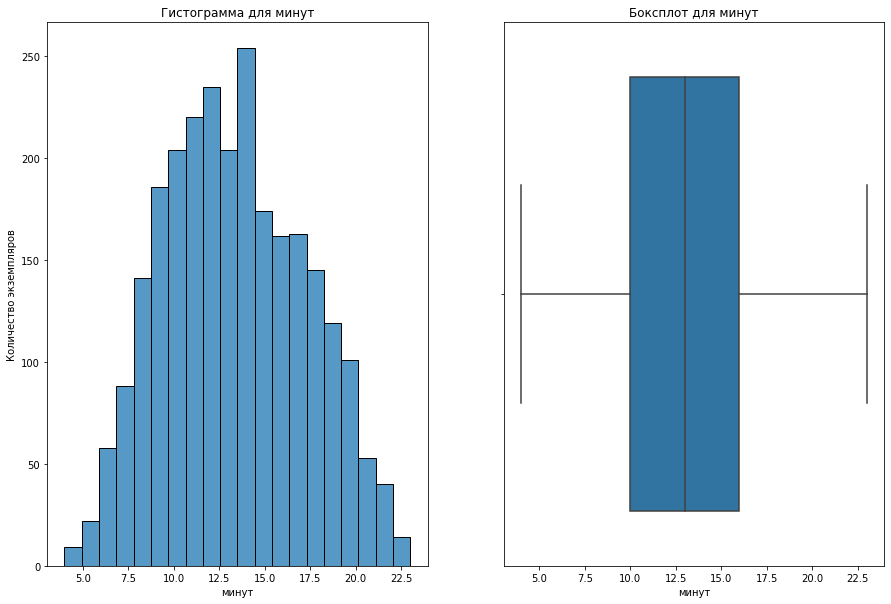

In [30]:
for column in market_time_num_columns:
	plotGraphsForContiniousColumn(column, bins = 20, dataFrame=market_time)

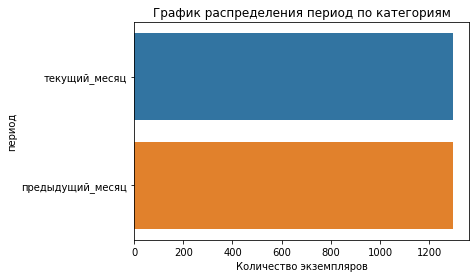

In [31]:
for column in market_time_cat_columns:
	plotHistForCategorialColumn(column, dataFrame=market_time)

<p>
	Проводим аналогичный набор операций для таблицы с информацией о проведенном на сайте времени, отметить какие-то аномалии не представляется возможным. 
</p>

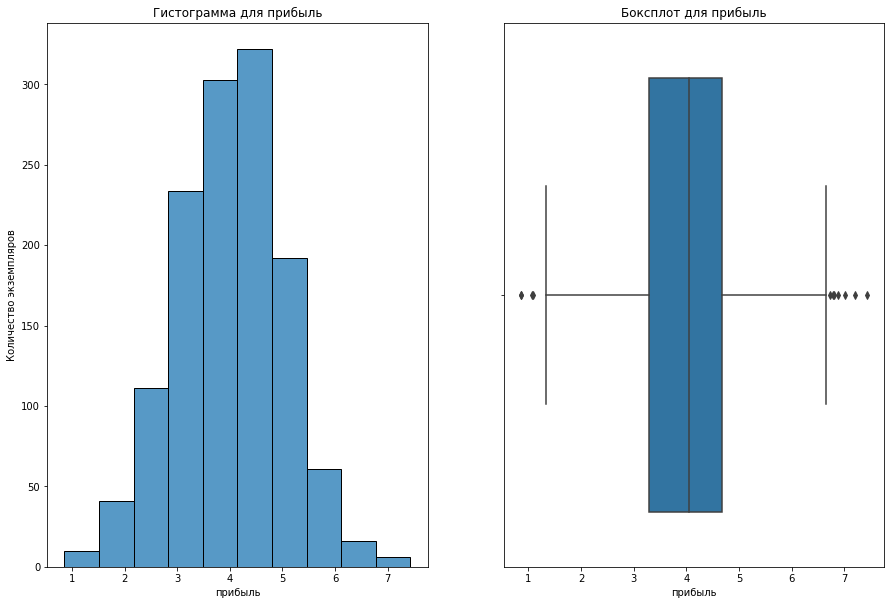

In [32]:
plotGraphsForContiniousColumn('прибыль', bins = 10, dataFrame=money_df)

<p>
	Аналогично для таблицы с прибылью. 
</p>

### Объединение данных в одну таблицу

In [33]:

pivot_money_table = market_money.pivot_table(index='id', columns=['период'])['выручка']
market_table = market_file.merge(pivot_money_table, on='id')
market_table = market_table.rename(columns= {
    'предыдущий_месяц': 'предыдущий_месяц_выручка',
    'препредыдущий_месяц': 'препредыдущий_месяц_выручка',
    'текущий_месяц': 'текущий_месяц_выручка'
})

pivot_time_table = market_time.pivot_table(index='id', columns=['период'])['минут']
market_table = market_table.merge(pivot_time_table, on='id')
market_table = market_table.rename(columns= {
    'предыдущий_месяц': 'предыдущий_месяц_минут',
    'текущий_месяц': 'текущий_месяц_минут'
})

print(market_table.isna().sum())
market_table['предыдущий_месяц_выручка'] = market_table['предыдущий_месяц_выручка'].fillna(0)
market_table['препредыдущий_месяц_выручка'] = market_table['препредыдущий_месяц_выручка'].fillna(0)
market_table['текущий_месяц_выручка'] = market_table['текущий_месяц_выручка'].fillna(0)
print(market_table.isna().sum())


id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_выручка                  0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
дли

In [34]:
market_table.shape

(1296, 18)

<p>
	Объединяем таблицы с основной информацией о пользовательском поведении с таблицами с информацией о времени на сайте и таблицей с выручкой, выводим получившуюся таблицу с агрегированными данными.  
</p>

In [35]:
market_table_continious_columns = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'страниц_за_визит',
    'предыдущий_месяц_выручка', 
    'препредыдущий_месяц_выручка', 
    'текущий_месяц_выручка',
    'предыдущий_месяц_минут',
    'текущий_месяц_минут'
]

market_table_discrete_columns = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса'
]


market_table_num_cols = market_table_continious_columns + market_table_discrete_columns

market_table_cat_cols = [
    'популярная_категория',
    'тип_сервиса',
    'разрешить_сообщать'
]

### Анализ корреляции

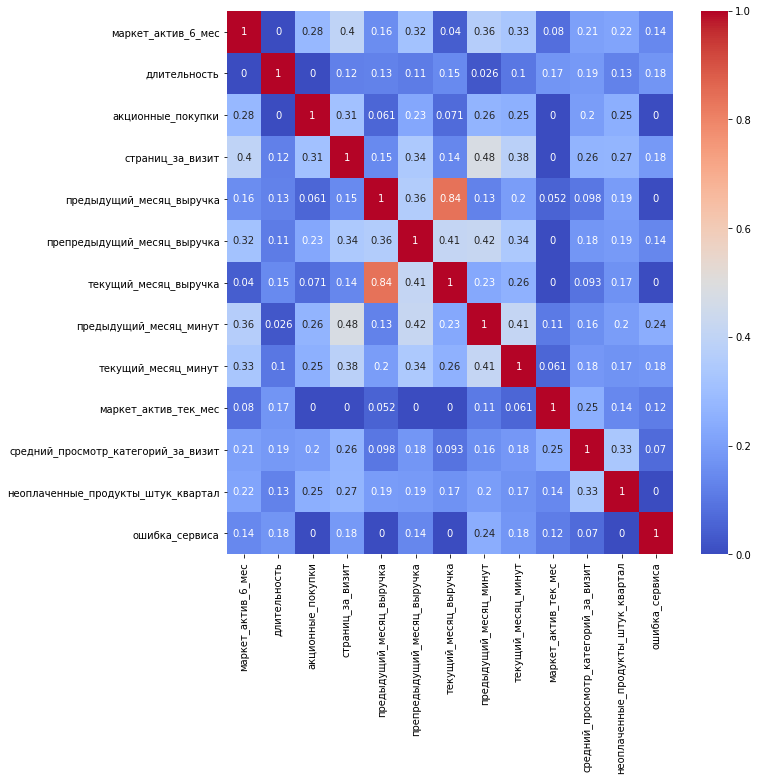

In [36]:
from phik import phik_matrix
correlation_matrix = phik_matrix(market_table[market_table_num_cols], interval_cols=market_table_continious_columns)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm', ax = ax);

In [37]:

X_ = sm.add_constant(market_table[market_table_num_cols])
 
vif = pd.DataFrame()
vif["variables"] = X_.columns
vif["VIF"] = [variance_inflation_factor(X_.values, i).round(2) for i in range(X_.shape[1])]

display(vif)

,variables,VIF
0,const,352.52
1,маркет_актив_6_мес,1.22
2,длительность,1.10
3,акционные_покупки,1.19
4,страниц_за_визит,1.42
5,предыдущий_месяц_выручка,4.26
6,препредыдущий_месяц_выручка,1.61
7,текущий_месяц_выручка,3.90
8,предыдущий_месяц_минут,1.53
9,текущий_месяц_минут,1.32


<p>
	Для анализа корреляций и потенциальных мультиколлинеарностей мы нарисуем матрицу корреляций и посчитаем вариационные факторы.  Из таблицы корреляций мы видим, что единственная существенная корреляция это корреляция между выручкой за текущий и предыдущий месяцы на одного клиента. Возможно в будущем стоит отказаться от одной из этих колонок как от избыточной. 
</p>
<p>
	Из таблицы инфляционных факторов мы видим, что все значения далеки от 10 (условный порог после которого мы точно считаем значение коррелирующим с остальными и подлежащим удалению из обучающего массива данных), но строки "предыдущий_месяц_выручка" и "текущий_месяц_выручка" имею значения существенно больше остальных, а "текущий_месяц_выручка" даже приближается к 5 (второй условный порог, на который стоит обратить внимание), что ещё раз указывает на возможно слишком сильную связть между данными.
</p>

In [38]:
RANDOM_STATE = 73

In [39]:
columns_to_drop = [
    'id',
	'покупательская_активность',
	'текущий_месяц_выручка'
	#'текущий_месяц_минут', 
	#'маркет_актив_тек_мес',
	#'предыдущий_месяц_выручка',
    #'препредыдущий_месяц_выручка',
    #'предыдущий_месяц_минут',
    #'маркет_актив_6_мес',
    #'неоплаченные_продукты_штук_квартал',
	]

def filter_columns(column):
	if column in columns_to_drop:
		return False
	else:
		return True

market_table_continious_columns_for_model = list(filter(filter_columns, market_table_continious_columns))
market_table_discrete_columns_for_model = list(filter(filter_columns, market_table_discrete_columns))
market_table_num_columns_for_model = market_table_continious_columns_for_model + market_table_discrete_columns_for_model
market_table_cat_columns_for_model = [
    'популярная_категория',
]
market_table_ord_columns_for_model = [
    'тип_сервиса',
    'разрешить_сообщать'
    ]
print(market_table_continious_columns_for_model)
print(market_table_discrete_columns_for_model)

['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'предыдущий_месяц_минут', 'текущий_месяц_минут']
['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']


In [40]:
cat_pipe = Pipeline(
	[
		('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
		('cat', OneHotEncoder(drop='first', handle_unknown='ignore'))
	]
	)

In [41]:
ord_pipe = Pipeline(
	[
		('simpleImputer_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
		('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
	]
	)

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, market_table_cat_columns_for_model),
		('ord', ord_pipe, market_table_ord_columns_for_model),
        ('num', MinMaxScaler(), market_table_num_columns_for_model)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

In [44]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':  range(2, 8),
        'models__max_features': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        #'models__C': range(1, 5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },  
	# словарь для полиномиальной модели SVC() 
    {
        'models': [SVC(random_state = RANDOM_STATE, kernel='poly', probability = True)],
        #'models__C': range(1, 5),
		'models__degree': range(1, 7), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
		# словарь для гауссовой модели SVC() 
    {
        'models': [SVC(random_state = RANDOM_STATE, kernel='rbf', probability = True)],
        #'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [45]:
X = market_table.drop(columns_to_drop, axis=1)
y = market_table['покупательская_активность']
display(X)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,12,10
1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,8,13
2,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,11,13
3,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,8,11
4,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,14,7
1292,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,12,11
1293,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,12,18
1294,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,18,7


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, 
    random_state = RANDOM_STATE,
    stratify = y)

labelIncoder = LabelEncoder()
y_train = labelIncoder.fit_transform(y_train)
y_test = labelIncoder.transform(y_test)

In [47]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [48]:
display(X_train)
display(y_train)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
780,стандарт,да,5.5,5,718,0.15,Мелкая бытовая техника и электроника,6,1,5,6,4790.5,4624.0,9,11
497,стандарт,да,4.9,4,399,0.25,Товары для детей,4,3,3,5,4307.0,4453.0,18,15
1242,стандарт,нет,4.1,5,468,0.23,Косметика и аксесуары,3,1,4,5,5190.5,5432.0,15,17
786,стандарт,нет,4.2,4,245,0.28,Домашний текстиль,4,2,5,6,5155.5,5202.0,20,12
84,стандарт,да,4.6,3,844,0.93,Товары для детей,3,8,4,2,5370.0,4752.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,премиум,нет,4.0,3,668,0.13,Товары для детей,5,1,2,9,5014.0,4527.0,19,16
67,премиум,да,3.4,4,806,0.93,Домашний текстиль,3,5,8,6,5816.5,4756.0,10,11
1245,стандарт,да,3.3,4,388,0.22,Домашний текстиль,4,3,4,13,5345.0,5219.0,14,16
1221,стандарт,нет,4.6,3,324,0.13,Товары для детей,6,1,4,6,6115.0,5386.0,20,23


array([0, 0, 0, ..., 0, 0, 1])

<p>
	Мы выбрали метрику "roc-auc" по той причине, что она оценивает качество модели наиболее общим способом, вне зависимости от порогов принадлежности к классу и прочего. 
</p>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нужно обосновать выбор метрики для оценки моделей.

<div class="alert alert-info">
    V_1 добавил комментарий
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [49]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleImputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_ord',
                                                                                          SimpleImputer(str...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='poly', probability=True,
                                         random_state=73)],
                          'models__degree': range(1, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=73)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [50]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели во время кросс валидации:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
           

In [51]:
predicted_proba = grid_search.predict_proba(X_test)[:, 1]
predictions = grid_search.predict(X_test)
print('Метрика roc-auc на тестовой выборке = ', roc_auc_score(y_test, predicted_proba))

Метрика roc-auc на тестовой выборке =  0.9304849739632348


In [52]:
print('Метрика recall = ', recall_score(y_test, predictions))
print('Метрика precision = ',precision_score(y_test, predictions))
print('Метрика accuracy = ',accuracy_score(y_test, predictions))

Метрика recall =  0.797979797979798
Метрика precision =  0.9294117647058824
Метрика accuracy =  0.9


<p>
	Строим пайплайн, который позволяет перебрать несколько моделей и параметров для них. Предварительно удаляем из таблицы целевой признак, информацию о выручке текущего месяца (её корреляция с прошлым около 0.8 и vif около 4, что уже близко к пороговым значениям)
</p>
<p>
	Самой эффективной моделью получается модель опорных векторов. Проверяя её на тестовых данных мы также видим хорошие показатели на всех базовых метриках. 
</p>

In [53]:
dummy_clf_1 = DummyClassifier(strategy="constant", constant=1)
dummy_clf_0 = DummyClassifier(strategy="constant", constant=0)

In [54]:
dummy_clf_1.fit(X_train, y_train)
dummy_clf_0.fit(X_train, y_train)

DummyClassifier(constant=0, strategy='constant')

In [55]:
dummy_predictions_1 = dummy_clf_1.predict(y_test)
dummy_predictions_0 = dummy_clf_0.predict(y_test)

In [56]:
print('Метрика recall (Dummy classifier, 1 prediction) = ', recall_score(y_test, dummy_predictions_1))
print('Метрика precision (Dummy classifier, 1 prediction) = ',precision_score(y_test, dummy_predictions_1))
print('Метрика accuracy (Dummy classifier, 1 prediction) = ',accuracy_score(y_test, dummy_predictions_1))

print('Метрика recall (Dummy classifier, 0 prediction) = ', recall_score(y_test, dummy_predictions_0))
print('Метрика accuracy (Dummy classifier, 0 prediction) = ',accuracy_score(y_test, dummy_predictions_0))

Метрика recall (Dummy classifier, 1 prediction) =  1.0
Метрика precision (Dummy classifier, 1 prediction) =  0.38076923076923075
Метрика accuracy (Dummy classifier, 1 prediction) =  0.38076923076923075
Метрика recall (Dummy classifier, 0 prediction) =  0.0
Метрика accuracy (Dummy classifier, 0 prediction) =  0.6192307692307693


<p>
	Чтобы убедиться в осмысленности полученной модели мы проводим базовое сравнение с "заглушками" вместо предсказательной модели, которые просто выдают постоянно 1 или 0. Из полученных метрик мы видим, что наша модель сильно лучше чем предсказания пустых моделей, значит мы по крайней мере предсказываем лучше чем константы. 
</p>

### Анализ важности признака

In [57]:
X_model_train = data_preprocessor.fit_transform(X_train)
X_model_test = data_preprocessor.transform(X_test)

In [58]:
model = SVC(probability=True, random_state=RANDOM_STATE)
model.fit(X_model_train, y_train)

SVC(probability=True, random_state=73)

In [59]:
feature_names = ['Косметика и аксесуары', 'Кухонная посуда',
 'Мелкая бытовая техника и электроника',
 'Техника для красоты и здоровья', 'Товары для детей',
       'тип_сервиса',
    'разрешить_сообщать'] + pipe_final.named_steps['preprocessor'].transformers_[2][2]

In [60]:
explainer = shap.Explainer(model.predict_proba, X_model_train)

In [61]:
shap_values = explainer(X_model_train)

PermutationExplainer explainer: 1037it [12:40,  1.35it/s]                          


In [62]:
shap_values.feature_names = feature_names

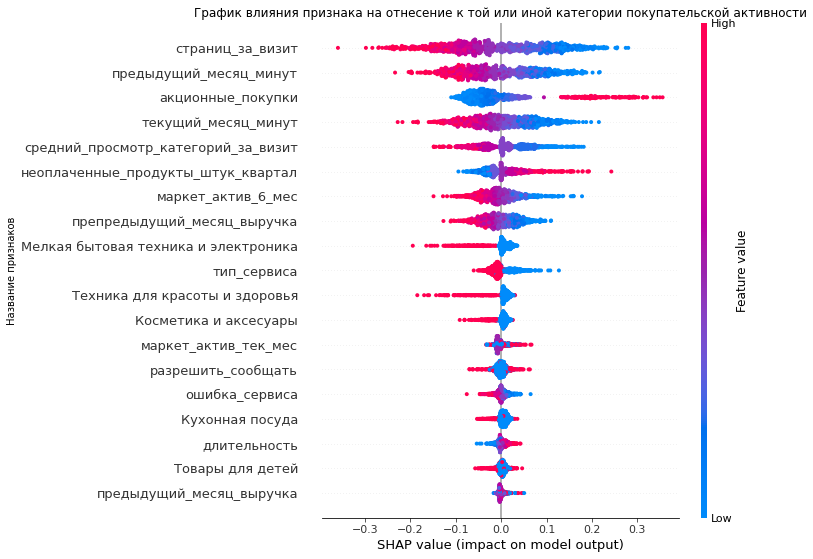

In [63]:
shap.plots.beeswarm(shap_values[: ,: ,1], max_display=20, show=False)
plt.title('График влияния признака на отнесение к той или иной категории покупательской активности')
plt.ylabel('Название признаков')

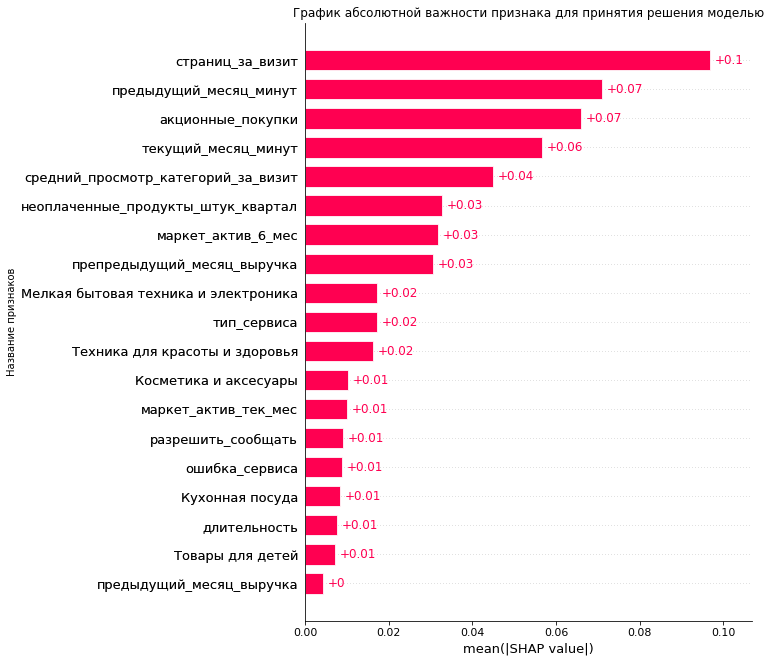

In [64]:
shap.plots.bar(shap_values[: ,: ,1], max_display=20, show = False)
plt.title('График абсолютной важности признака для принятия решения моделью')
plt.ylabel('Название признаков');

<p>
	Воспроизводим предобработку данных и модель чтобы оценить каким образом она принимает "решения". При помощи библиотеки shap строим два вида графиков - абсолютной значимости признака (второй график) и того в сторону какого решения отдельный признак смещает модель. Видно что самые важные признаки это количество страниц за визит, время за предыдущий месяц, параметр акционных покупок и средний просмотр категорий за визит. 
</p>

In [65]:
actioners = market_table.query('акционные_покупки > 0.6')
display(actioners)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
11,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13,13
13,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,216602,Прежний уровень,стандарт,нет,3.4,5,170,0.95,Техника для красоты и здоровья,4,1,3,10,5221.0,4887.0,5058.5,17,11
1252,216604,Прежний уровень,стандарт,да,4.9,5,350,0.99,Домашний текстиль,3,4,5,5,4545.0,4735.0,4840.1,14,14
1253,216605,Прежний уровень,стандарт,да,3.2,4,568,0.94,Мелкая бытовая техника и электроника,5,1,7,11,4921.0,5212.0,4798.8,14,22
1288,216640,Прежний уровень,стандарт,нет,5.7,4,416,0.95,Кухонная посуда,2,3,5,13,4212.5,4679.0,3938.2,23,17


In [66]:
for column in market_table_num_cols:
	print(actioners[column].describe())
	print(market_table[column].describe())

count    166.000000
mean       3.781928
std        1.078567
min        0.900000
25%        3.300000
50%        4.000000
75%        4.400000
max        5.700000
Name: маркет_актив_6_мес, dtype: float64
count    1296.000000
mean        4.256404
std         1.013525
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64
count     166.000000
mean      604.054217
std       240.564293
min       147.000000
25%       436.500000
50%       613.000000
75%       800.750000
max      1064.000000
Name: длительность, dtype: float64
count    1296.000000
mean      602.967593
std       249.195823
min       121.000000
25%       409.500000
50%       606.500000
75%       806.250000
max      1079.000000
Name: длительность, dtype: float64
count    166.000000
mean       0.942711
std        0.038414
min        0.740000
25%        0.930000
50%        0.940000
75%        0.980000
max        0.990000
Name: акционные_покупки,

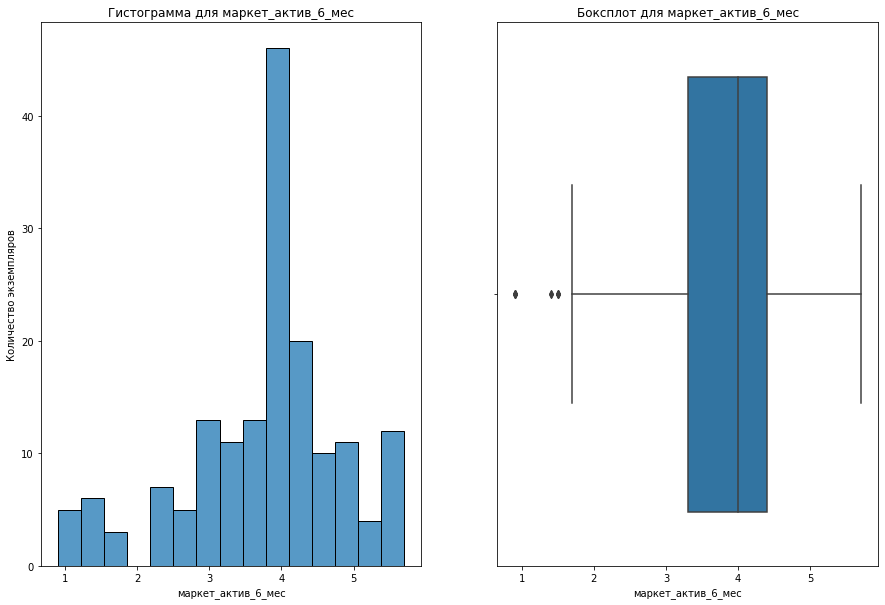

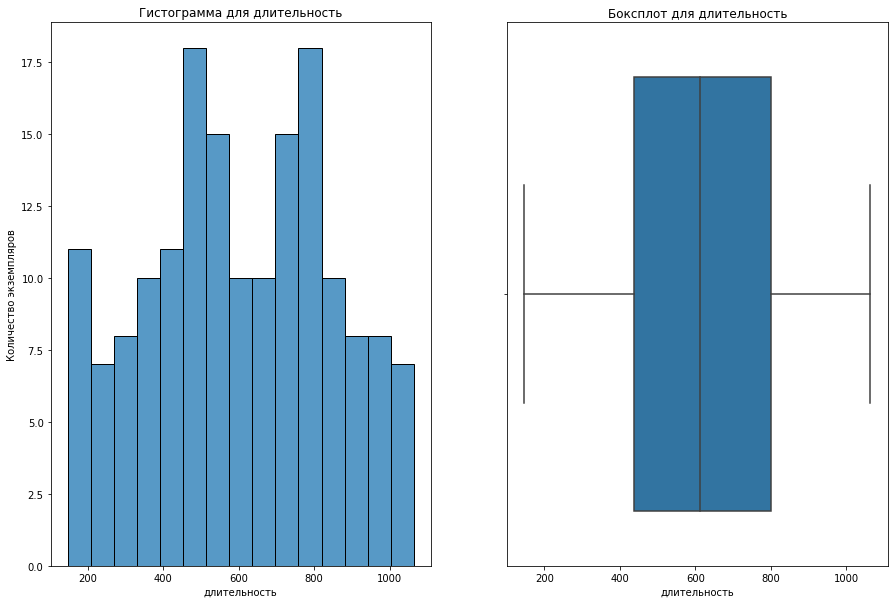

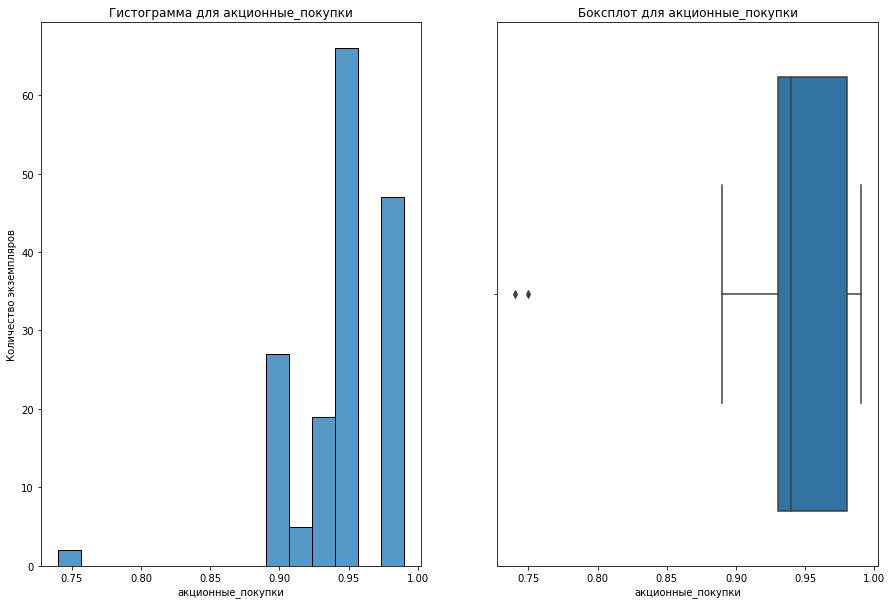

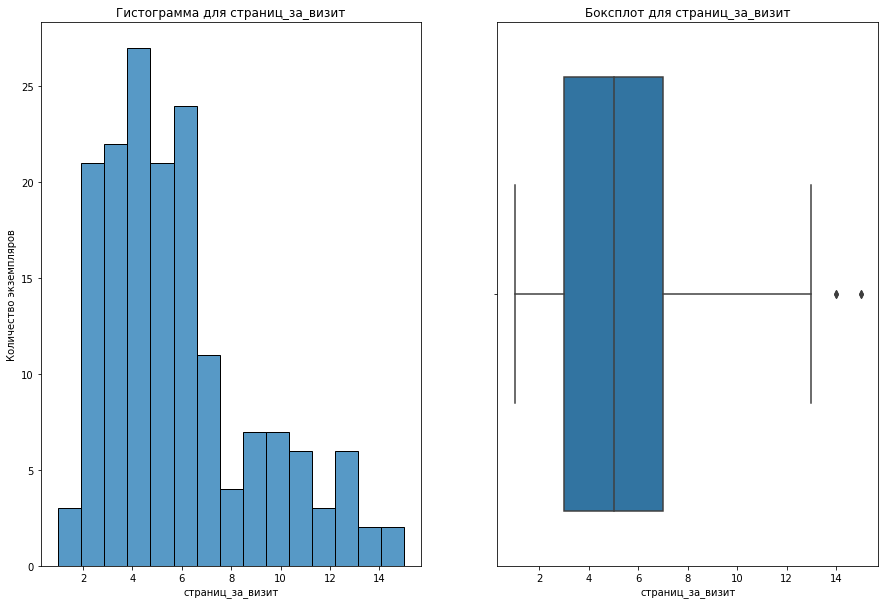

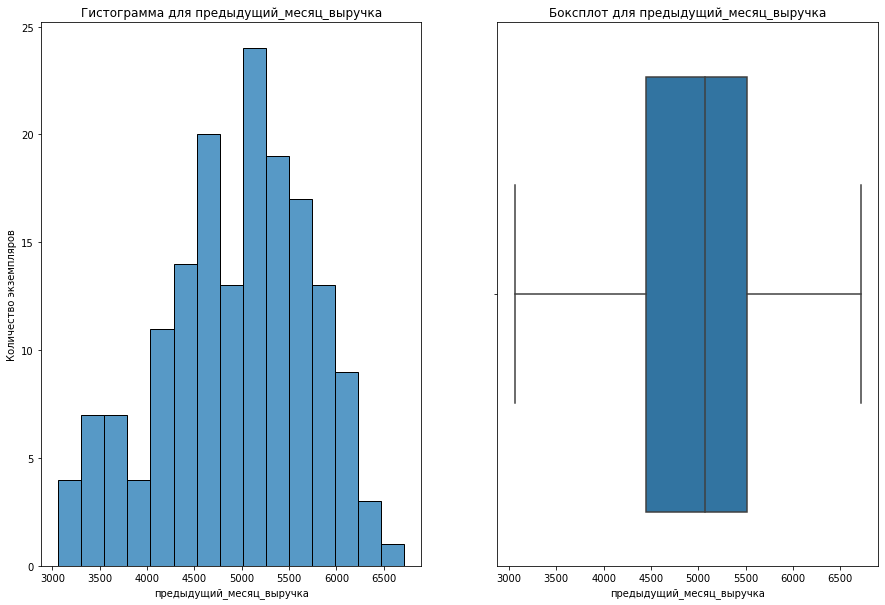

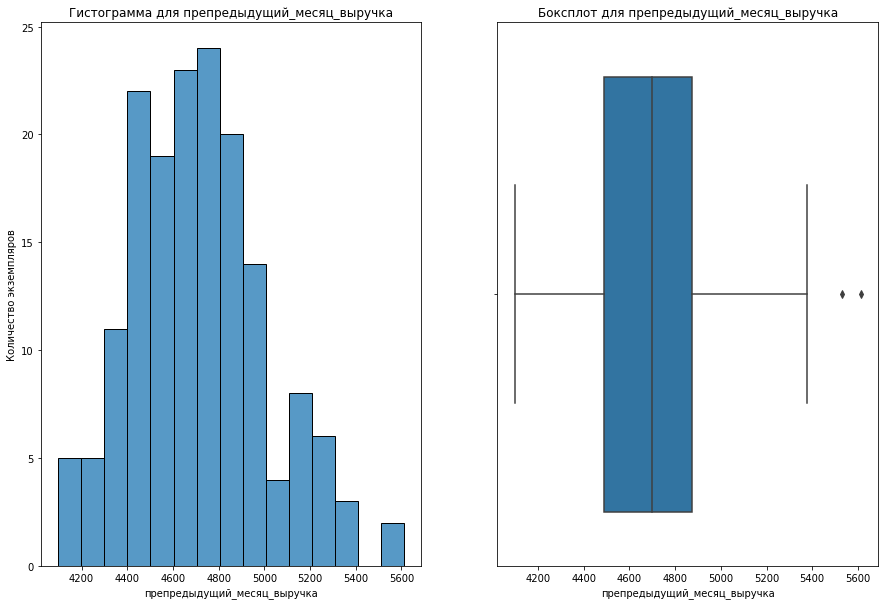

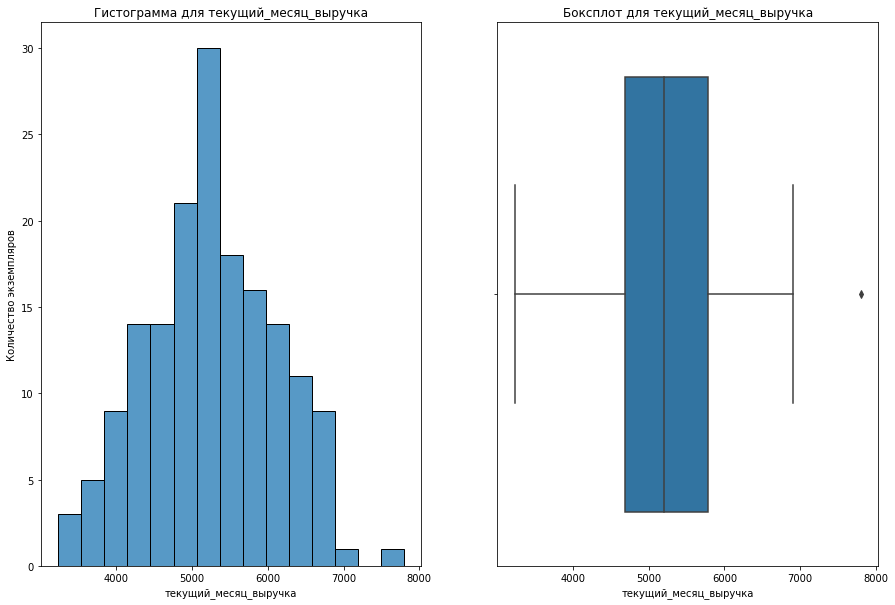

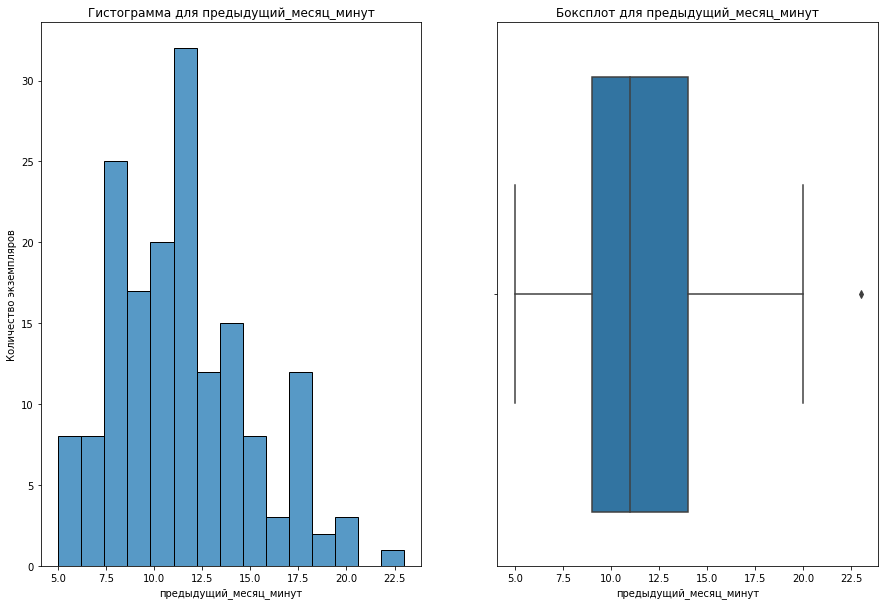

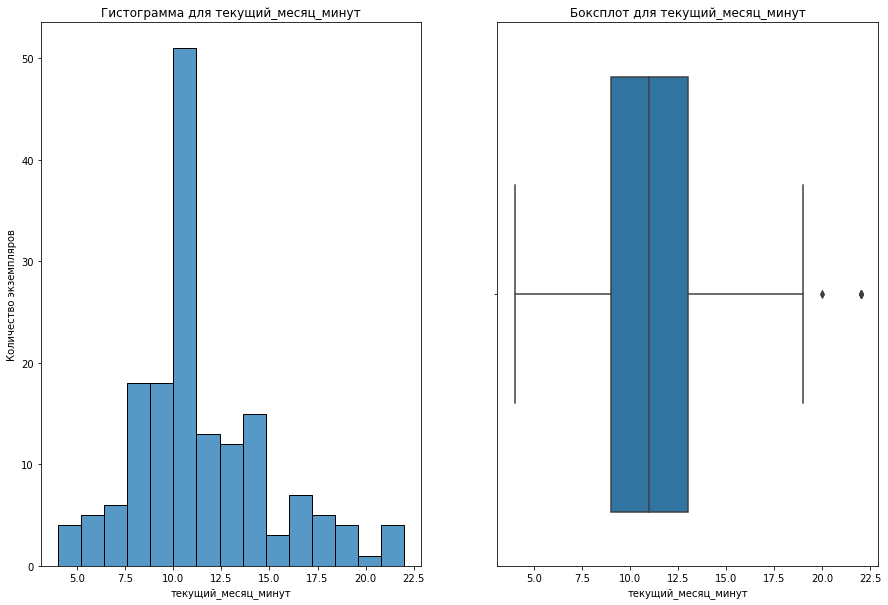

In [67]:
for column in market_table_continious_columns:
	plotGraphsForContiniousColumn(column, bins = 15, dataFrame=actioners)

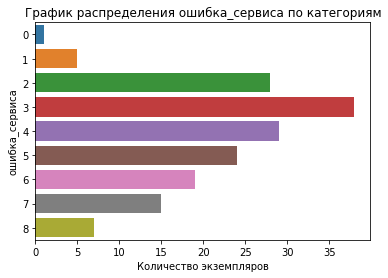

In [68]:
plotHistForCategorialColumn('ошибка_сервиса', dataFrame=actioners)

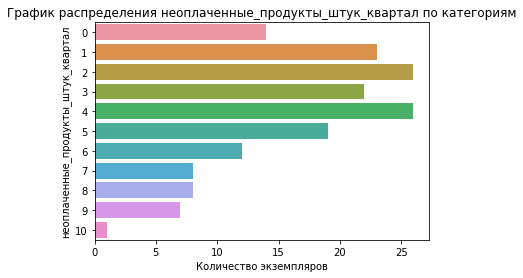

In [69]:
plotHistForCategorialColumn('неоплаченные_продукты_штук_квартал', dataFrame=actioners)

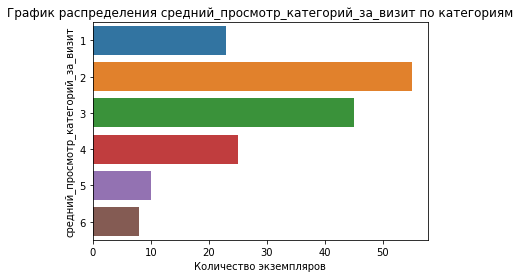

In [70]:
plotHistForCategorialColumn('средний_просмотр_категорий_за_визит', dataFrame=actioners)

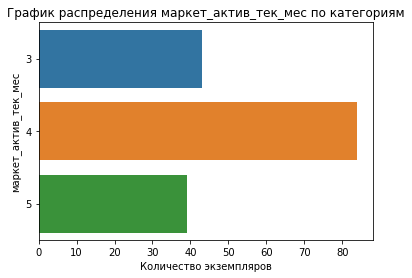

In [71]:
plotHistForCategorialColumn('маркет_актив_тек_мес', dataFrame=actioners)

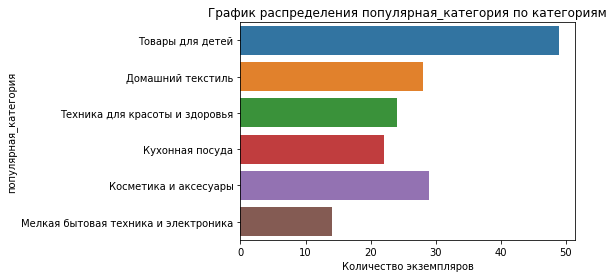

In [72]:
plotHistForCategorialColumn('популярная_категория', dataFrame=actioners)

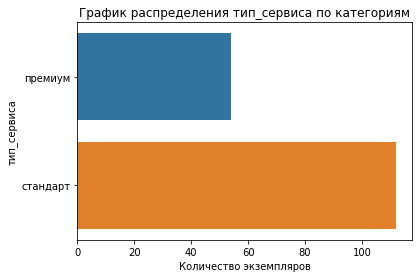

In [73]:
plotHistForCategorialColumn('тип_сервиса', dataFrame=actioners)

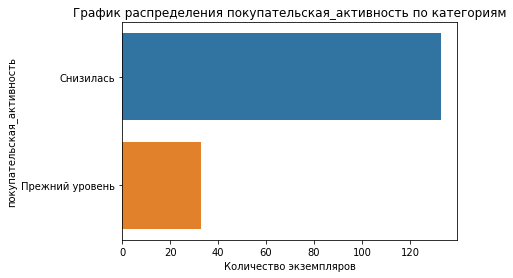

In [74]:
plotHistForCategorialColumn('покупательская_активность', dataFrame=actioners)

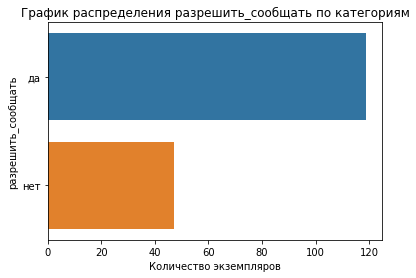

In [75]:
plotHistForCategorialColumn('разрешить_сообщать', dataFrame=actioners)

<p>
	Мы видим, что в выбранном сегменте пользователей данные выглядят похожим на основной массив данных образом, но можно выделить два заметных отличия: 
</p>
<p>
	1) Первое это перекос в сторону снизившийся покупательской активности. Это неплохой признак с той точки зрения, что значит именно для этой группы пользователей мы можем придумать некоторую стратегию улучшения целевого показателя.  
</p>
<p>
	2) Второе это заметно снизившееся количество просмотренных страниц за визит. Это скорее всего означает, что пользователи чаще приходят за конкретным товаром.   
</p>
</p>
	Можно было бы подумать, что это менее обеспеченные пользователи, но показатели их выручки не отличаются от основного массива данных. Рабочее предложение для дополнительного привлечения пользователей из данной категории это увеличить число акционных кампаний, возможно снизить размер акций (чтобы не нести слишком большой дополнительной финансовой нагрузки), но нарастить количество товаров по акции, это возможно увеличит показатель покупательской активности для данной категории пользователей. 
<p>

### Вывод

<p>
	Целью нашей работы было исследование пользовательского поведения пользователей и построение модели для предсказания этого поведения. 
</p>
<p>
	В первой части мы произвели более или менее стандартную предобработку данных - привели названия столбцов к единому формату, проверили данные на дубликаты и пропуски. Затем мы провели анализ с точки зрения структуры данных - посмотрели на характерные значения для количественных столбцов, построили графики. Удалил явные выбросы из данных. Заметили, что пользователей можно разбить на группы по различным признакам: акционной активности, прибыли, маркетинговой активности и прочее. 
</p>
<p>
	Затем мы объединили данные из трёх таблиц в одну и посмотрели на данные с точки зрения корреляционного анализа - проверили на мультиколлинеарность. Посчитали инфляционные факторы, чтобы дополнительно проверить неявные зависимости между признаками, которые могут помешать успешному моделированию. По результату сильных корреляций, которые могут нарушить моделирование, выявлено не было.
</p>
<p>
	Следующим шагом мы строим пайплайн для выбора лучше модели, пайплайн состоит из этапа пребобработки данных и непосредственного моделирования. Готовый пайплайн мы передаём в GridSearchCV вместе с сеткой параметров, которая перебирает несколько моделей с внутренними параметрами: Логистическая регрессия, дерева приняти решений, модели knn и метода опорных векторов. Затем получившуюся конструкцию мы обучаем на тренировочных данных полученных из объединенной таблицы, предварительно убирая из данных для анализа столбцы, которые создают утечку данных - всю информацию о текущем месяце. Наиболее эффективной с точки зрения метрики roc-auc получилась модель опорных векторов. Далее мы дополнительно считаем метрики модели на тестовых данных. 
</p>
<p>
	Затем мы анализируем лучшую модель с точки зрения того как она принимает "решения". Самыми важными для модели категориями являются это количество страниц за визит, время за предыдущий месяц, параметр акционных покупок и средний просмотр категорий за визит. Наглядные графики, которые показывают важность отдельных признаков, можно найти в соответствующем пункте.
</p>
<p>
	В конце работы мы рассматриваем массив данных о пользователях с точки зрения сегментации их на подгруппы - возможно несколько различных сегментаций: по выручке с пользователя, по акционным покупкам, по маркетинговой активности, по отсутствию выручки в определенном месте. В данной работе для более подробного рассмотрения был выбран способ разбиения по доле акционных покупок на пользователя, так как на соответсвующем графике было четко видно две отдельные группы пользователей, и они явно должны различаться по покупательскому поведению, что может означать возможность некоей специальной стратегии для каждой группы. 
</p>
<p>
	По реузльтатам анализа мы видим, что главные отличия "акционной" группы от остальных - покупательская активность и среднее количество просматриваемых страниц за визит(причём выручка с пользователя практически не отличается от основного массива данных). Это наталкивает нас на мысль, что это группа людей, которые обращают внимание на акции (возможно внешние) и как правило приходят купить конкретный товар по акции. При этом их покупательская активность существенно более низкая чем в общем датафрейме, а значит имеет смысл в рамках локального улудшения целевого показателя ориентироваться на эту группу. Рабочее предложение состоит в достаточно простой идее: увеличить количество акционных товаров (возможно за счёт частичного снижения размера скидок) и увчеличить размещение рекламы скидок на внешних площадках (или уведомлений целевого сегмента пользоватей о скидках в магазине, если есть такая возможность), так как данная группа явно склонна к покупкам по скидке/акции. Возможно стоит отдельно проанализировать несколько других групп, чтобы также проверить их на потенциальную возможность для улучшения целевого показателя.
</p>